In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras import Input;
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
from google.cloud import storage
from google.colab import files

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srivallimedicharla","key":"6509194e62ad6bb09aa30c73a3d80545"}'}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d emmarex/plantdisease

100% 655M/658M [00:03<00:00, 238MB/s]
100% 658M/658M [00:03<00:00, 217MB/s]


In [7]:
!unzip plantdisease.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-74

In [10]:
diseaseTypes = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
dataDir = 'plantvillage/PlantVillage/'
trainDir = os.path.join(dataDir)
#test_dir = os.path.join(data_dir, 'test')

In [12]:
trainData = []
for defects_id, sp in enumerate(diseaseTypes):
    for file in os.listdir(os.path.join(trainDir, sp)):
        trainData.append(['{}/{}'.format(sp, file), defects_id, sp])
        
traiin = pd.DataFrame(trainData, columns=['File', 'DiseaseID','Disease Type'])
traiin.tail()

,File,DiseaseID,Disease Type
20634,Tomato_healthy/43c4b555-4bc4-470f-9150-ef0a7b5...,14,Tomato_healthy
20635,Tomato_healthy/2aeb668a-251a-4f68-b52f-aadeb33...,14,Tomato_healthy
20636,Tomato_healthy/56a12dcc-cd88-47c3-97b2-8c3a33f...,14,Tomato_healthy
20637,Tomato_healthy/71c4512d-05ba-456f-ba4e-f2861b7...,14,Tomato_healthy
20638,Tomato_healthy/16ed4e23-5218-4e8b-85df-86a7069...,14,Tomato_healthy


In [13]:
SEED = 42
traiin = traiin.sample(frac=1, random_state=SEED) 
traiin.index = np.arange(len(traiin)) # Reset indices
traiin.head()

,File,DiseaseID,Disease Type
0,Tomato_healthy/e7a9a772-95f5-4bd4-ad34-831c3c4...,14,Tomato_healthy
1,Potato___Early_blight/811eba3a-112e-43dd-8b22-...,2,Potato___Early_blight
2,Tomato_Septoria_leaf_spot/609fec75-fdd5-4adc-8...,9,Tomato_Septoria_leaf_spot
3,Tomato_healthy/0aacdad5-c9b9-4309-96e3-0797bbe...,14,Tomato_healthy
4,Tomato_Leaf_Mold/81ea3777-2cc4-473a-bbeb-062bd...,8,Tomato_Leaf_Mold


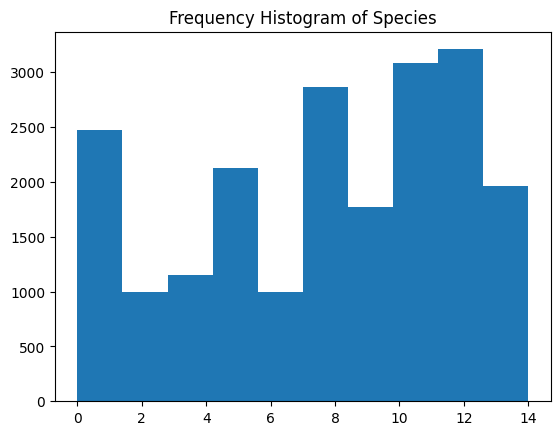

<Figure size 1200x1200 with 0 Axes>

In [14]:
plt.hist(traiin['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

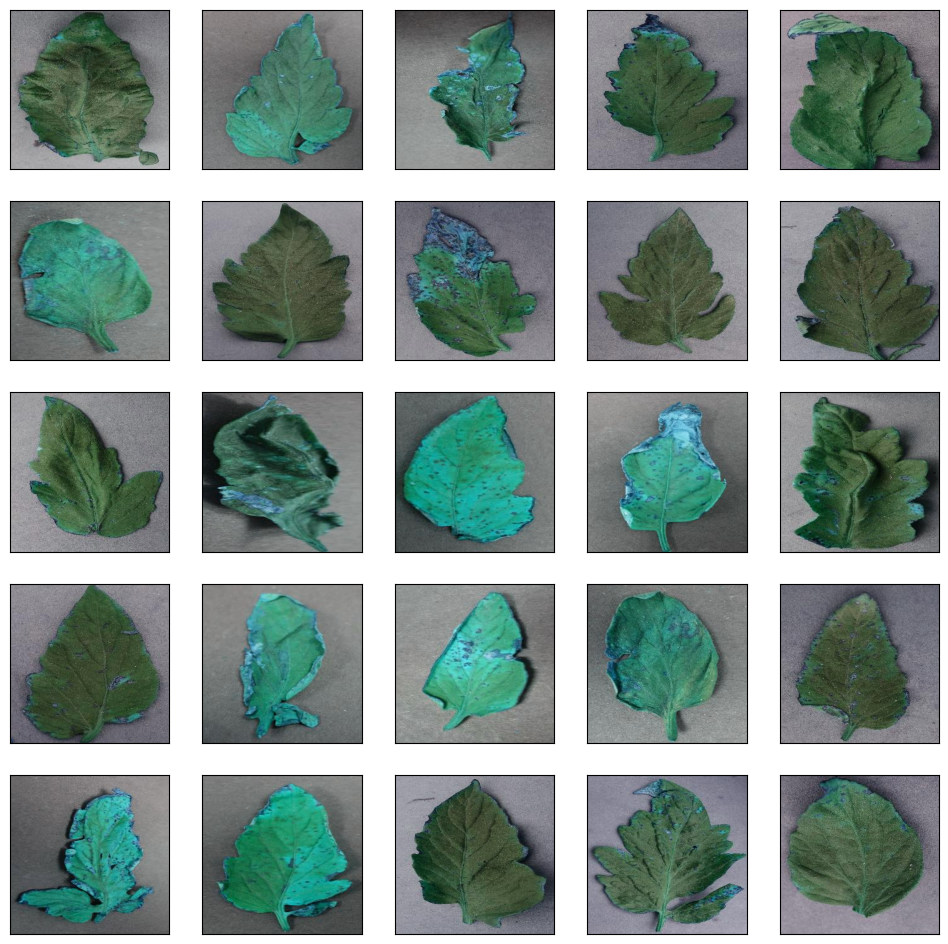

In [15]:
def plotDefects(defectTypes, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = traiin['File'][traiin['Disease Type'] == defectTypes].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(dataDir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plotDefects('Tomato_Bacterial_spot', 5, 5)

In [16]:
IMAGE_SIZE = 64

def readImage(filepath):
    return cv2.imread(os.path.join(dataDir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resizeImage(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [17]:
X_train = np.zeros((traiin.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(traiin['File'].values)):
    image = readImage(file)
    if image is not None:
        X_train[i] = resizeImage(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

20639it [00:31, 650.52it/s]


Train Shape: (20639, 64, 64, 3)


In [18]:
Y_train = traiin['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [19]:
BATCH_SIZE = 256

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

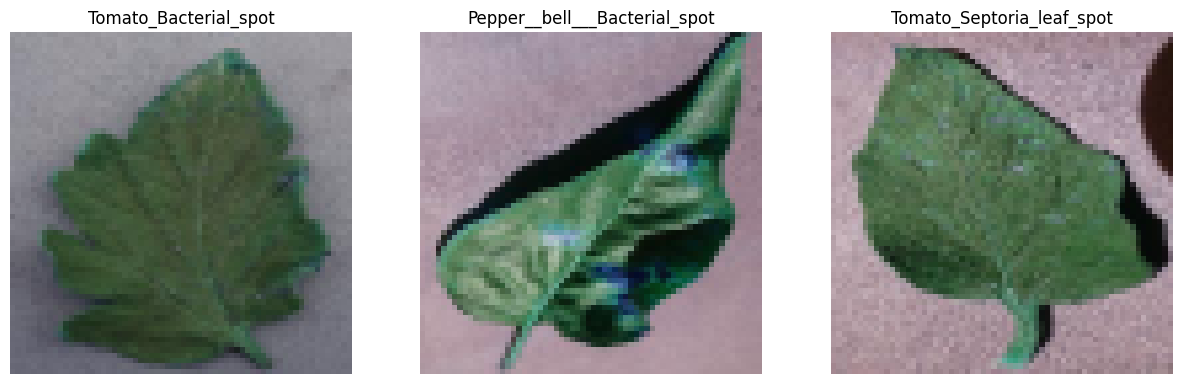

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(diseaseTypes[np.argmax(Y_train[i])])

In [21]:
EPOCHS = 5
SIZE=64
N_ch=3

In [22]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [23]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),epochs=EPOCHS,validation_data=(X_val, Y_val))

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                              

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
65/65 [==============================] - 1202s 18s/step - loss: 3.6400 - accuracy: 0.1145 - val_loss: 2.6677 - val_accuracy: 0.1713
Epoch 2/5
65/65 [==============================] - 1161s 18s/step - loss: 2.3734 - accuracy: 0.3241 - val_loss: 2.1637 - val_accuracy: 0.3467
Epoch 3/5
65/65 [==============================] - 1173s 18s/step - loss: 1.6148 - accuracy: 0.5199 - val_loss: 1.5447 - val_accuracy: 0.5746
Epoch 4/5
65/65 [==============================] - 1172s 18s/step - loss: 1.1777 - accuracy: 0.6391 - val_loss: 1.3454 - val_accuracy: 0.6579
Epoch 5/5
65/65 [==============================] - 1144s 18s/step - loss: 0.8976 - accuracy: 0.7161 - val_loss: 1.3772 - val_accuracy: 0.6383


In [24]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

129/129 [==============================] - 52s 406ms/step - loss: 1.3772 - accuracy: 0.6383
Final Loss: 1.3771734237670898, Final Accuracy: 0.6383236646652222


129/129 [==============================] - 64s 450ms/step


Text(0.5, 192.58159722222217, 'Predicted')

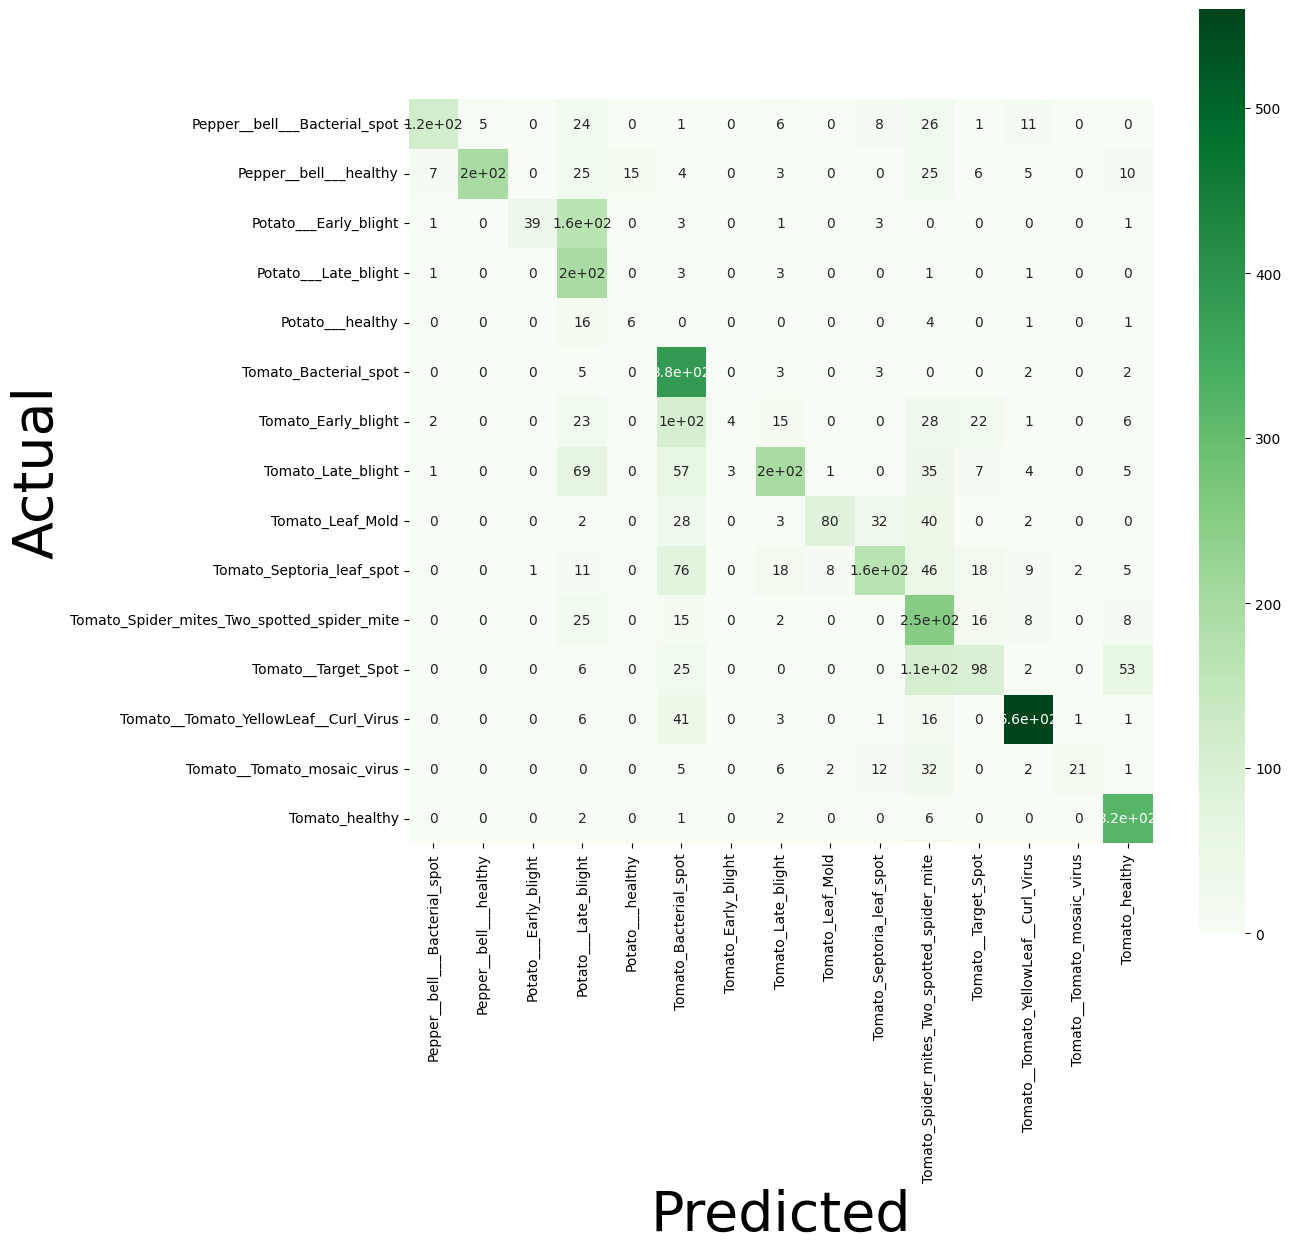

In [25]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

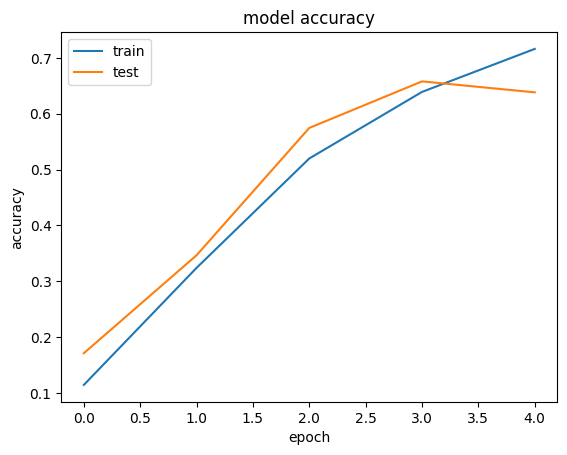

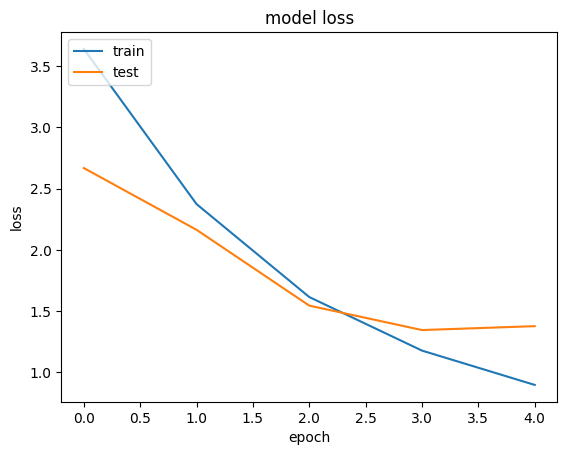

In [26]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 2s 2s/step
[0.06915429 0.00837995 0.4101547  0.38956833 0.02455879 0.00303263
 0.0008664  0.00376271 0.01030388 0.01612862 0.02686562 0.01638789
 0.00056885 0.00878922 0.0114781 ]


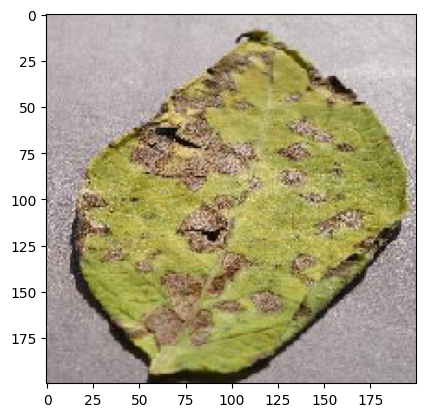

Prediction: Potato___Early_blight


In [28]:
from skimage import io
import keras.utils as image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('plantvillage/PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG', grayscale=False, target_size=(64, 64))
show_img=image.load_img('plantvillage/PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG', grayscale=False, target_size=(200, 200))
disease_class = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255

custom = model.predict(x)
print(custom[0])



#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])